This notebook takes 1 March - 31 October. It uses 4 weeks of data to predict the next 2 weeks

In [1]:
import numpy as np
import matplotlib.pylab as plt
from pandas import read_csv
import matplotlib.pyplot
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from datetime import date, timedelta
from sklearn.metrics import r2_score

In [2]:
cases = pd.read_csv("time_series_covid19_confirmed_US.csv")
deaths  = pd.read_csv("time_series_covid19_deaths_US.csv")
density = pd.read_csv("popden.csv")

In [3]:
fips = cases[(cases['10/31/20']<10000)]
fips = fips[(fips['10/31/20']>1000)]

f = fips['FIPS'].tolist()
cases = cases[cases['FIPS'].isin(f)]
deaths = deaths[deaths['FIPS'].isin(f)]

In [4]:
density.drop_duplicates(subset=['fips'],keep='last',inplace=True)

strings = {'NMR','PR','VI','KSC','NYC'}
index_names = density[(density['fips']).isin(strings)].index
density.drop(index_names, inplace=True)

density['fips']=density['fips'].astype(float)

In [5]:
c = pd.merge(cases,density, left_on='FIPS',right_on='fips')
d = pd.merge(deaths,density, left_on='FIPS',right_on='fips')

In [6]:
col = {'UID','iso2','iso3','code3','FIPS','Admin2','Province_State','Country_Region','Lat','Long_','Combined_Key','date','county','state','fips','cases','deaths','stay_at_home_announced','stay_at_home_effective','lat','lon','total_population','area_sqmi'}
c.drop(c.columns[c.columns.isin(col)],axis=1,inplace=True)
d.drop(d.columns[d.columns.isin(col)],axis=1,inplace=True)

In [7]:
from sklearn.preprocessing import minmax_scale
d['population_density_per_sqmi']=minmax_scale(d['population_density_per_sqmi'])
c['population_density_per_sqmi']=minmax_scale(c['population_density_per_sqmi'])

In [8]:
c

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,2/16/21,2/17/21,2/18/21,2/19/21,2/20/21,2/21/21,2/22/21,2/23/21,2/24/21,population_density_per_sqmi
0,0,0,0,0,0,0,0,0,0,0,...,6038,6050,6071,6079,6092,6117,6121,6143,6172,0.008940
1,0,0,0,0,0,0,0,0,0,0,...,19176,19267,19324,19361,19392,19433,19461,19554,19635,0.012209
2,0,0,0,0,0,0,0,0,0,0,...,2055,2053,2057,2061,2067,2070,2074,2084,2095,0.002726
3,0,0,0,0,0,0,0,0,0,0,...,5987,5997,6008,6021,6040,6042,6043,6058,6072,0.008631
4,0,0,0,0,0,0,0,0,0,0,...,1910,1924,1930,1934,1938,1940,1945,1948,1951,0.002332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1032,0,0,0,0,0,0,0,0,0,0,...,3867,3871,3871,3880,3880,3887,3893,3892,3893,0.000617
1033,0,0,0,0,0,0,0,0,0,0,...,4639,4643,4643,4646,4646,4647,4649,4652,4655,0.000740
1034,0,0,0,0,0,0,0,0,0,0,...,4718,4743,4754,4764,4764,4792,4810,4816,4825,0.000177
1035,0,0,0,0,0,0,0,0,0,0,...,8098,8109,8116,8122,8122,8126,8135,8141,8145,0.003306


In [9]:
cases.fillna(0,inplace=True)
deaths.fillna(0,inplace=True)

deaths_results_MAE = np.zeros(15)
cases_results_MAE = np.zeros(15)

deaths_results_RMSE = np.zeros(15)
cases_results_RMSE = np.zeros(15)

deaths_score = np.zeros(15)
cases_score = np.zeros(15)

In [10]:
testx = {'population_density_per_sqmi'}
for i in range(1,29):
    s = '12/'+str(i)+'/20'
    testx.add(s)
testy = {'12/29/20'}
for i in range(30,32):
    s = '12/'+str(i)+'/20'
    testy.add(s)
for i in range(1,12):
    s = '1/'+str(i)+'/21'
    testy.add(s)

In [26]:
x_date = date(2020,3,1)
y_date = date(2020,3,29)
delta = timedelta(days=14)

for j in range (0,15):
    
    x_days = {'population_density_per_sqmi'}
    for i in range(0,28):
        s = x_date + timedelta(days=i)
        x_days.add(s.strftime("%-m/%-d/%y"))
    y_days = {y_date.strftime("%-m/%-d/%y")}
    for i in range(1,14):
        s = y_date + timedelta(days=i)
        y_days.add(s.strftime("%-m/%-d/%y"))
       
    X_train =deaths.filter(x_days)
    y_train = deaths.filter(y_days)
    
    X_test = deaths.filter(testx)
    y_test = deaths.filter(testy)
    
    
    #X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=.2,random_state=42)
    reg = MLPRegressor(random_state=1, max_iter=1500).fit(X_train,y_train)
    deaths_results_MAE[j]=mean_absolute_error(y_test.astype(int),reg.predict(X_test).astype(int))
    deaths_results_RMSE[j]=mean_squared_error(y_test.astype(int),reg.predict(X_test).astype(int))
    deaths_score[j] = r2_score(y_test,reg.predict(X_test))
    x_date += delta
    y_date += delta

/root/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [12]:
deaths_results_RMSE

array([286262.25741368,  15438.86723087,   2886.48097495,    624.66120515,
         1020.59140149,    631.34475288,    849.13554502,   1463.79404198,
          703.5788084 ,   1127.54218009,   1308.0464455 ,   1217.24001354,
         1409.82477996,    996.50656737,    813.67725118])

In [13]:
deaths_results_MAE

array([333.84807041,  63.67968856,  32.10859851,  12.49004739,
        17.71475965,  13.34962762,  15.12227488,  22.33432634,
        14.12017603,  18.85660122,  20.40812458,  19.7       ,
        21.62924848,  17.39647935,  15.48551117])

In [14]:
deaths_score

array([-22.17439431,  -0.25723508,   0.77942761,   0.95268397,
         0.92298877,   0.9537323 ,   0.93722052,   0.889886  ,
         0.94827957,   0.91563889,   0.90237685,   0.90898081,
         0.89425479,   0.9258684 ,   0.93965158])

In [15]:
x_date = date(2020,3,1)
y_date = date(2020,3,29)
delta = timedelta(days=14)

for j in range (0,15):
    
    x_days = {'population_density_per_sqmi'}
    for i in range(0,28):
        s = x_date + timedelta(days=i)
        x_days.add(s.strftime("%-m/%-d/%y"))
    y_days = {y_date.strftime("%-m/%-d/%y")}
    for i in range(1,14):
        s = y_date + timedelta(days=i)
        y_days.add(s.strftime("%-m/%-d/%y"))
       
    X_train = cases.filter(x_days)
    y_train = cases.filter(y_days)
    
    X_test = cases.filter(testx)
    y_test = cases.filter(testy)
    
    #X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=.2,random_state=42)
    reg = MLPRegressor(random_state=1, max_iter=1500).fit(X_train,y_train)
    cases_results_MAE[j]=mean_absolute_error(y_test.astype(int),reg.predict(X_test).astype(int))
    cases_results_RMSE[j]=mean_squared_error(y_test.astype(int),reg.predict(X_test).astype(int))
    cases_score[j] = r2_score(y_test,reg.predict(X_test))
    x_date += delta
    y_date += delta

In [16]:
cases_results_MAE

array([41348.39783345,  3374.89404198,  1240.50162492,   988.29329722,
        1870.06025728,   737.28111036,  1097.63053487,  2411.55802302,
         511.77298578,  1173.89695328,  1455.08659445,  1623.50900474,
        1427.33926879,  1185.53155044,  1143.68348003])

In [17]:
cases_results_RMSE

array([3.44642358e+09, 2.61083566e+07, 3.98733754e+06, 2.07425830e+06,
       6.60683975e+06, 1.57455741e+06, 2.84419603e+06, 1.13975290e+07,
       7.08284760e+05, 3.10174928e+06, 4.41777359e+06, 5.36316627e+06,
       4.21783103e+06, 3.03304990e+06, 2.85600506e+06])

In [18]:
cases_score

array([-120.84755795,    0.12215179,    0.86731291,    0.93051168,
          0.77849412,    0.94904847,    0.90680208,    0.61411486,
          0.97712837,    0.89752507,    0.85360916,    0.8199743 ,
          0.85914137,    0.89919523,    0.9053316 ])

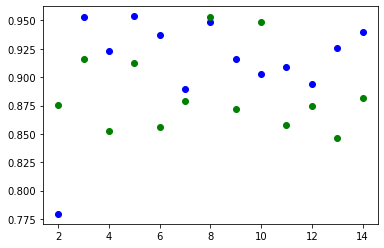

In [19]:
x_axis = np.arange(0,15)

d_score1 = deaths_score
d_score2 = np.asarray([-47.78997426,   0.66963482,   0.8759063 ,   0.9161301 ,
         0.85292508,   0.91223095,   0.85647065,   0.87933048,
         0.9528111 ,   0.8721048 ,   0.94849844,   0.85795159,
         0.87432541,   0.84626768,   0.88123666])
plt.plot(x_axis[2:],d_score1[2:],'bo')
plt.plot(x_axis[2:],d_score2[2:],'go')

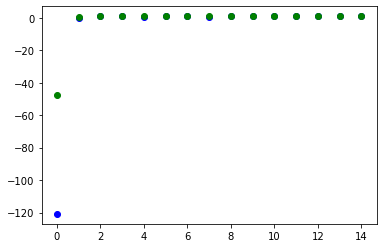

In [20]:
c_score1 = cases_score
c_score2 = np.asarray([-47.78997426,   0.66963482,   0.8759063 ,   0.9161301 ,
         0.85292508,   0.91223095,   0.85647065,   0.87933048,
         0.9528111 ,   0.8721048 ,   0.94849844,   0.85795159,
         0.87432541,   0.84626768,   0.88123666])
plt.plot(x_axis,c_score1,'bo')
plt.plot(x_axis,c_score2,'go')

<AxesSubplot:xlabel='Date', ylabel='Number of New COVID-19 Cases'>

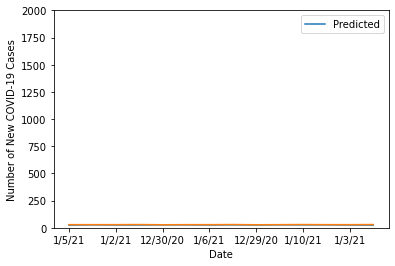

In [29]:
pred = reg.predict(X_test).astype(int)
y1_train = pd.DataFrame(data=pred[1000],columns=['Predicted'])
y1_test = y_test.iloc[1000]
y1_train.plot.line(ylim=(0,2000),xlabel='Date',ylabel='Number of New COVID-19 Cases')
y1_test.plot.line(label='Actual')

In [36]:
y1_train

,Predicted
0,25
1,27
2,26
3,26
4,27
5,27
6,26
7,27
8,26
9,27


In [37]:
#y1_train = y_train.iloc[100]
d_axis = date(2020,12,29)
date_axis = {d_axis.strftime("%-m/%-d/%y")}
for i in range(0,14):
    s = d_axis + timedelta(days=i)
    date_axis.add(s.strftime("%-m/%-d/%y"))

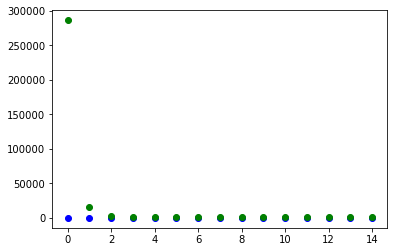

In [22]:
plt.plot(x_axis,deaths_results_MAE,'bo')
plt.plot(x_axis,deaths_results_RMSE,'go')
#plt.plot(x_axis,deaths_results_MAE*len(x),'ro')

NameError: name 'x' is not defined

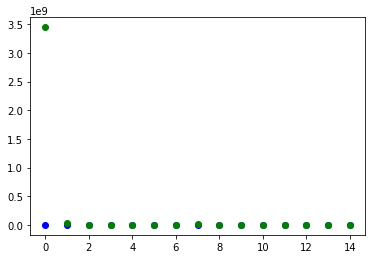

In [23]:
plt.plot(x_axis,cases_results_MAE,'bo')
plt.plot(x_axis,cases_results_RMSE,'go')
plt.plot(x_axis,cases_results_MAE*len(x),'ro')

In [ ]:
plt.plot(x_axis,cases_score,'yo')
plt.plot(x_axis,deaths_score,'ko')

In [43]:
x_date = date(2020,3,29)
y_date = date(2020,4,26)
   
x_days = {'population_density_per_sqmi'}
for i in range(0,28):
    s = x_date + timedelta(days=i)
    x_days.add(s.strftime("%-m/%-d/%y"))
y_days = {y_date.strftime("%-m/%-d/%y")}
for i in range(1,14):
    s = y_date + timedelta(days=i)
    y_days.add(s.strftime("%-m/%-d/%y"))
       
X_train = cases.filter(x_days)
y_train = cases.filter(y_days)
    
X_test = cases.filter(testx)
y_test = cases.filter(testy)
    
reg_case = MLPRegressor(random_state=1, max_iter=1500).fit(X_train,y_train)

<AxesSubplot:xlabel='Date', ylabel='Number of New COVID-19 Cases'>

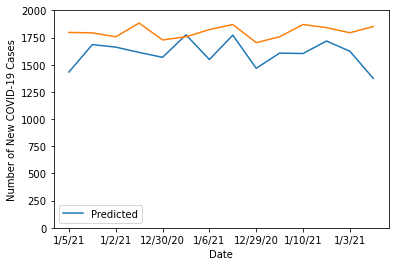

In [44]:
pred = reg_case.predict(X_test).astype(int)
y1_train = pd.DataFrame(data=pred[1000],columns=['Predicted'])
y1_test = y_test.iloc[1000]
y1_train.plot.line(ylim=(0,2000),xlabel='Date',ylabel='Number of New COVID-19 Cases')
y1_test.plot.line(label='Actual')

In [48]:
x_date = date(2020,8,30)
y_date = date(2020,9,27)
   
x_days = {'population_density_per_sqmi'}
for i in range(0,28):
    s = x_date + timedelta(days=i)
    x_days.add(s.strftime("%-m/%-d/%y"))
y_days = {y_date.strftime("%-m/%-d/%y")}
for i in range(1,14):
    s = y_date + timedelta(days=i)
    y_days.add(s.strftime("%-m/%-d/%y"))
       
X_train = deaths.filter(x_days)
y_train = deaths.filter(y_days)
    
X_test = deaths.filter(testx)
y_test = deaths.filter(testy)
    
reg_death = MLPRegressor(random_state=1, max_iter=1500).fit(X_train,y_train)

<AxesSubplot:xlabel='Date', ylabel='Number of New COVID-19 Deaths'>

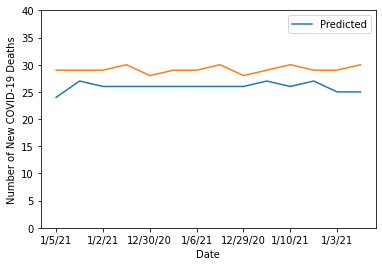

In [49]:
pred = reg_death.predict(X_test).astype(int)
y1_train = pd.DataFrame(data=pred[1000],columns=['Predicted'])
y1_test = y_test.iloc[1000]
y1_train.plot.line(ylim=(0,40),xlabel='Date',ylabel='Number of New COVID-19 Deaths')
y1_test.plot.line(label='Actual')

In [50]:
y1_train

,Predicted
0,24
1,27
2,26
3,26
4,26
5,26
6,26
7,26
8,26
9,27


In [51]:
y1_test

1/5/21      29
1/4/21      29
1/2/21      29
1/11/21     30
12/30/20    28
12/31/20    29
1/6/21      29
1/9/21      30
12/29/20    28
1/1/21      29
1/10/21     30
1/7/21      29
1/3/21      29
1/8/21      30
Name: 3166, dtype: int64